# 1. Install dependencies and import required libraries


In [1]:
!pip install scipy 
!pip install pytorch-lightning
!pip install optuna 

import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.utils.data as data
import pylab
import urllib
from PIL import Image
from torchvision import transforms
from scipy.interpolate import interp1d
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
from torch import Tensor
from tqdm import tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#2. Load the DeepLabv3 model with a ResNet-50 backbone

In [2]:
torch.manual_seed(12)
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 181MB/s]


#3. Download and preprocess the input image



In [3]:
url, filename = ("https://b2cfurniture.com.au/pub/media/catalog/product/cache/3fb871f48f7af5e44260f2d9fd3932a9/e/l/elm-modern-hardwood-dining-chair-black-hardwood-frame-eco-friendly-beige-fabric_3_.jpg", "lw4.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open('lw4.jpg')
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)


#4. Move the input and model to GPU if available



In [4]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')


#5. Generate the output and predictions



In [5]:
with torch.no_grad():
    model.eval()
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)
print(output_predictions.shape)

torch.Size([525, 700])


#6. Define the plot_img function to visualize the segmented image



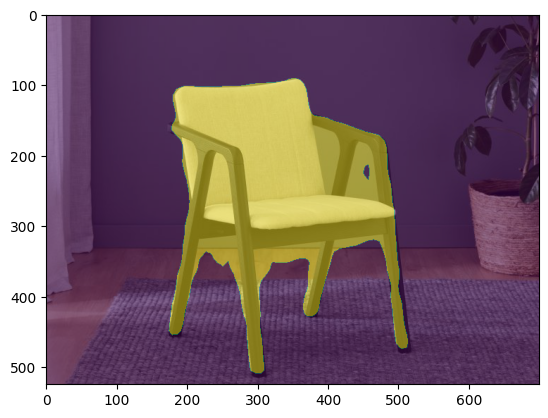

In [6]:
def plot_img():
    r = Image.fromarray(model(input_batch)['out'][0].argmax(0).byte().cpu().numpy()).resize(input_image.size)
    rix = np.array(r)
    a = np.where(rix == 9, rix, 0)
    plt.imshow(a)
    plt.imshow(input_image)
    plt.imshow(a, alpha=0.5)
    plt.show()

plot_img()


#7. Define the area_of_class1 function to calculate the area of class 1



In [7]:
def area_of_class1(model):
    with torch.no_grad():
        model.eval()
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    result = np.array(Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size))
    result2 = torch.where(torch.tensor(np.array(result)) == 9, 1, 0)
    resulted = torch.sum(result2)
    return resulted

print(area_of_class1(model))


tensor(76541)


#8. Extract the weights from the last layer of the model



In [8]:
w_default = torch.squeeze(model.classifier[4].weight.clone())[9]
w_real_default = w_default.detach().clone().cpu().numpy()


#9. Define the neuron_projection function to project the neurons



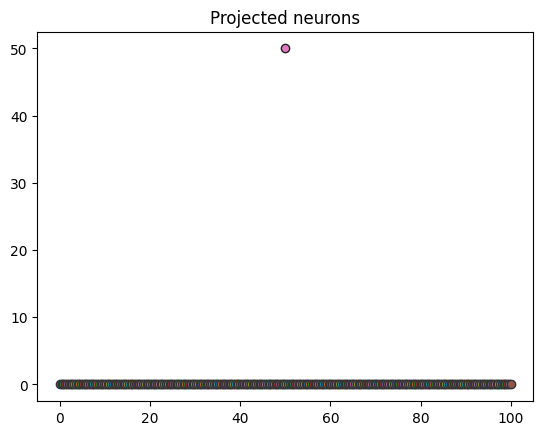

In [9]:
def neuron_projection(weights_of_final_layer):
  end_neuron_projected = np.array([50, 50])
  final_layer_project = np.linspace(0, 100, len(weights_of_final_layer))
  return end_neuron_projected, final_layer_project, len(weights_of_final_layer), np.arange(len(weights_of_final_layer))

def plot_neurons(end_neuron_proj, final_layer_proj, length):
  for i in range(length):
      plt.scatter(final_layer_proj[i], 0, edgecolor="#333")
  plt.scatter(end_neuron_proj[0], end_neuron_proj[1], edgecolor="#222")
  plt.title("Projected neurons")
  plt.show()

end_neuron_proj, final_layer_proj, length, non_negative_indexes = neuron_projection(w_real_default)
plot_neurons(end_neuron_proj, final_layer_proj, length)


#10. Define the `interpfun` function to create the interpolation function and plot it

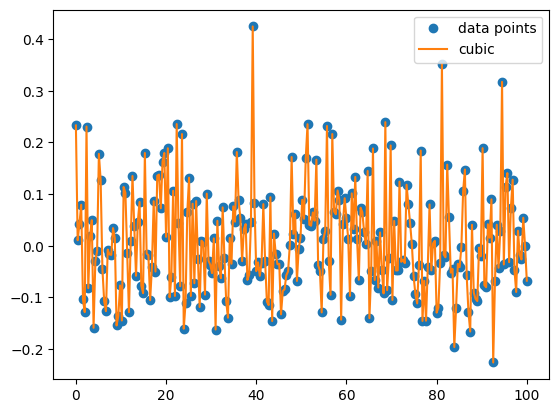

In [10]:
def interpfun(points, values):
    f_cubic = interp1d(points, values, kind="cubic")
    return f_cubic

def plot_interp(f_cubic, points, values):
    pylab.plot(points, values, 'o', label='data points')
    pylab.plot(points, f_cubic(points), label='cubic')
    pylab.legend()
    pylab.show()

points = torch.linspace(0, 100, length)
values = w_real_default
f_cubic = interpfun(points, values)
plot_interp(f_cubic, points, values)

#11. Define the final_layer_weight_modifier function to modify the final layer weights



In [11]:
def final_layer_weight_modifier(weight_gradients, modification, non_negative_indexes, f_cubic):
    points = torch.linspace(0, 100, len(non_negative_indexes))
    points_2 = points
    weight_gradients2 = weight_gradients
    for i in range(len(points)):
        points_2[i] = (points[i] + modification) % 100
    weight_gradients2 = torch.Tensor(f_cubic(points_2))
    return weight_gradients2

#12. Optimize the area of class 1 using Optuna



In [12]:
import optuna

def objective(trial):
    sum1 = area_of_class1(model)
    x = trial.suggest_float('x', 99, 101)
    with torch.no_grad():
        model.classifier[4].weight[9] = torch.nn.parameter.Parameter(torch.unsqueeze(torch.unsqueeze(final_layer_weight_modifier(w_real_default, x, non_negative_indexes, f_cubic), dim=-1), dim=-1))
    sum2 = area_of_class1(model)
    with torch.no_grad():
        model.classifier[4].weight[9] = torch.nn.parameter.Parameter(torch.unsqueeze(torch.unsqueeze(w_default, dim=-1), dim=-1))
    return abs(sum2 - (sum1 * 0.91))

study = optuna.create_study(pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=500)
best_param = study.best_params['x']
print(best_param)


[I 2023-05-07 20:56:09,617] A new study created in memory with name: no-name-5d728acc-d3ac-4ed9-98b3-89fefeb00306
[I 2023-05-07 20:56:10,005] Trial 0 finished with value: 69652.3125 and parameters: {'x': 100.65050992776895}. Best is trial 0 with value: 69652.3125.
[I 2023-05-07 20:56:10,309] Trial 1 finished with value: 69652.3125 and parameters: {'x': 99.21135534157641}. Best is trial 0 with value: 69652.3125.
[I 2023-05-07 20:56:10,603] Trial 2 finished with value: 69652.3125 and parameters: {'x': 99.74624770761153}. Best is trial 0 with value: 69652.3125.
[I 2023-05-07 20:56:10,900] Trial 3 finished with value: 69652.3125 and parameters: {'x': 99.46760979779546}. Best is trial 0 with value: 69652.3125.
[I 2023-05-07 20:56:11,189] Trial 4 finished with value: 69652.3125 and parameters: {'x': 100.60137822918308}. Best is trial 0 with value: 69652.3125.
[I 2023-05-07 20:56:11,482] Trial 5 finished with value: 4559.6875 and parameters: {'x': 99.97506350454715}. Best is trial 5 with valu

99.91629059694338


#13. Modify the weights of the model using the best parameter



In [13]:
with torch.no_grad():
    model.classifier[4].weight[9] = torch.nn.parameter.Parameter(torch.unsqueeze(torch.unsqueeze(final_layer_weight_modifier(w_real_default, best_param, non_negative_indexes, f_cubic), dim=-1), dim=-1))


#14. Print the final area of class 1 and visualize the modified segmented image



tensor(69718)


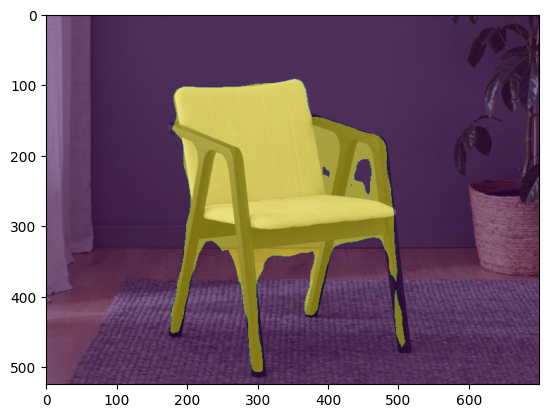

In [14]:
print(area_of_class1(model))
plot_img()